In [1]:
import nltk
#nltk.download('cess_esp')
from nltk.corpus import cess_esp
#from sklearn.model_selection import train_test_split
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt
from math import sqrt

In [2]:
corpus_data = cess_esp.tagged_sents()

In [3]:
res = []
for oracion in corpus_data:
    aux = []
    for palabra,categoria in oracion:
        if palabra !="*0*":
            aux.append((palabra,categoria[0:3]) if categoria[0] == "v" or categoria[0] == "F" else (palabra,categoria[0:2]))
    res.append(aux)

In [4]:
len(res) == len(corpus_data)

True

In [5]:
lenCorpusTok = len(res)
train=res[:9*lenCorpusTok//10]
test=res[9*lenCorpusTok//10:]


Modelo de unigramas:

In [6]:
tagger_unigramas = UnigramTagger(train) #Entrenamos el modelo de unigramas

In [7]:
#Etiquetamos una oración
palabras = [w for w,c in test[0]]
print(palabras)
prediccion = tagger_unigramas.tag(palabras) #Generamos una predicción
for palabra,categoria in prediccion:
    print("%s | %s" %(palabra,categoria))

['Y', 'al_final', 'le', 'pedía', 'que', 'colabore', 'conmigo', 'en', 'la', 'campaña', 'electoral', 'vasca', '-', '.']
Y | cc
al_final | rg
le | pp
pedía | vmi
que | pr
colabore | None
conmigo | None
en | sp
la | da
campaña | nc
electoral | aq
vasca | aq
- | Fg
. | Fp


In [8]:
#Evaluamos las prestaciones
tagger_unigramas.evaluate(test)

0.8054935238945958

Modelo de Bigramas sin suavizado

In [9]:
tagger_bigramas = BigramTagger(train)
tagger_bigramas.evaluate(test)
#Al no existir suavizado el modelo no es capaz de generalizar adecuadamente
#por lo que no se consiguen buenas predicciones

0.11820753312490695

Modelo de Bigramas con suavizado

In [10]:
tagger_bigramas = BigramTagger(train,backoff=tagger_unigramas)
tagger_bigramas.evaluate(test)
#El suavizado permite mejores generalizaciones por parte del modelo

0.8188179246687509

# HMM

In [11]:
#Entrenamos el modelo
tagger_hmm = hmm.HiddenMarkovModelTagger.train(train)

In [12]:
#Prediccion para una oración
palabras = [w for w,c in test[0]]
print(palabras)
prediccion = tagger_hmm.tag(palabras) #Generamos una predicción
for palabra,categoria in prediccion:
    print("%s | %s" %(palabra,categoria))

['Y', 'al_final', 'le', 'pedía', 'que', 'colabore', 'conmigo', 'en', 'la', 'campaña', 'electoral', 'vasca', '-', '.']
Y | cc
al_final | rg
le | pp
pedía | vmi
que | cs
colabore | vai
conmigo | vmp
en | sp
la | da
campaña | nc
electoral | aq
vasca | aq
- | Fg
. | Fp


In [13]:
#Evaluamos el modelo basado en Hidden Markov Models
tagger_hmm.evaluate(test)

0.8784427571832664

# TNT

In [14]:
#Entrenamos el modelo
tagger_TNT = tnt.TnT()
tagger_TNT.train(train)

In [15]:
#Prediccion para una frase
palabras = [w for w,c in test[0]]
print(palabras)
prediccion = tagger_TNT.tag(palabras) #Generamos una predicción
for palabra,categoria in prediccion:
    print("%s | %s" %(palabra,categoria))

['Y', 'al_final', 'le', 'pedía', 'que', 'colabore', 'conmigo', 'en', 'la', 'campaña', 'electoral', 'vasca', '-', '.']
Y | cc
al_final | rg
le | pp
pedía | vmi
que | cs
colabore | Unk
conmigo | Unk
en | sp
la | da
campaña | nc
electoral | aq
vasca | aq
- | Fg
. | Fp


In [16]:
#Evaluamos el modelo
tagger_TNT.evaluate(test)

0.8255173440524044

# Cross Validation sin barajar


In [17]:

k = 10
tamañoParticion = int(len(res)/k)
particiones = [res[i*tamañoParticion :i*tamañoParticion +tamañoParticion] for i in range(k)]

In [18]:
def cross_validation(clasificador,k,datosParticionados):
    precisiones = []
    for i in range(k):
        train = datosParticionados.copy()
        test = train[i]
        del train[i]
        train = [val for sublist in train for val in sublist]#Aplano las listas de listas de listas
        tagger = clasificador.train(train[0:-1])
        precisiones.append(tagger.evaluate(test))
    return precisiones

In [19]:
precisiones_HMM_no_barajo = cross_validation(hmm.HiddenMarkovModelTagger,10,particiones)
precisiones_HMM_no_barajo

[0.9284063638787663,
 0.9238470598894627,
 0.9228301472203911,
 0.9251021133013674,
 0.9228631913204551,
 0.8781806196440343,
 0.8878207393793737,
 0.8914285714285715,
 0.8912859560067682,
 0.8784427571832664]

In [20]:
precisiones_TNT_no_barajo = []
for i in range(k):
    train = particiones.copy()
    test = train[i]
    del train[i]
    tagger_TNT = tnt.TnT()
    train = [val for sublist in train for val in sublist] #aplanamos la lista
    tagger = tagger_TNT.train(train[0:-1])
    precisiones_TNT_no_barajo.append(tagger_TNT.evaluate(test))

In [21]:
precisiones_TNT_no_barajo

[0.8963203270820371,
 0.8886019751744133,
 0.8865304328718963,
 0.889540046172971,
 0.8927846873070477,
 0.838892551087673,
 0.8582738389764615,
 0.850780559646539,
 0.8591370558375635,
 0.8255173440524044]

# Cross validation barajando

In [22]:
from random import shuffle

In [23]:
datos_barajados = shuffle(res)

In [24]:
k = 10
tamañoParticion = int(len(res)/k)
particiones = [res[i*tamañoParticion :i*tamañoParticion +tamañoParticion] for i in range(k)]

In [25]:
precisiones_HMM_barajo = cross_validation(hmm.HiddenMarkovModelTagger,10,particiones)


In [26]:
precisiones_TNT_barajo = []
for i in range(k):
    train = particiones.copy()
    test = train[i]
    del train[i]
    tagger_TNT = tnt.TnT()
    train = [val for sublist in train for val in sublist] #aplanamos la lista
    tagger = tagger_TNT.train(train[0:-1])
    precisiones_TNT_barajo.append(tagger_TNT.evaluate(test))

In [27]:
precisiones_HMM_barajo

[0.9292374913411839,
 0.9265448683503493,
 0.9286820105274022,
 0.9258635644675749,
 0.9259435962680237,
 0.9259377664109122,
 0.9249826842133305,
 0.9238984597219986,
 0.9233354673495519,
 0.9229286058593541]

In [28]:
precisiones_TNT_barajo

[0.9044599563062823,
 0.9012358946802794,
 0.9073175766332955,
 0.8992805755395683,
 0.9010814249363868,
 0.9019075021312873,
 0.9013799349992008,
 0.8977083668759728,
 0.9004481434058899,
 0.8993626479567244]

In [29]:
def scuadrado(values):
    media = sum(values)/len(values)
    scuadrado = sum([(value-media)**2 for value in values]) / len(values)
    res = "[%.4f, %.4f]" %(media-scuadrado,media+scuadrado)
    return res

In [30]:
def accuracy95(p,ndatos):
    return 1.95*sqrt(p*(1-p) /ndatos)

In [31]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_HMM_no_barajo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM')
plt.plot(x,y,'ro')
Tic=[accuracy95(p,len(res)//k) for p in results]# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

<Figure size 640x480 with 1 Axes>

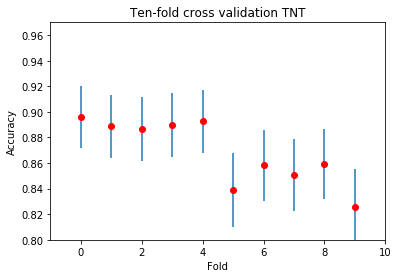

In [32]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_TNT_no_barajo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation TNT')
plt.plot(x,y,'ro')
Tic=[accuracy95(p,len(res)//k) for p in results]# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

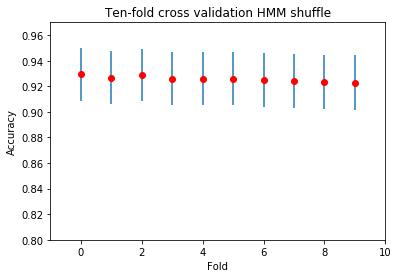

In [33]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_HMM_barajo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM shuffle')
plt.plot(x,y,'ro')
Tic=[accuracy95(p,len(res)//k) for p in results]# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

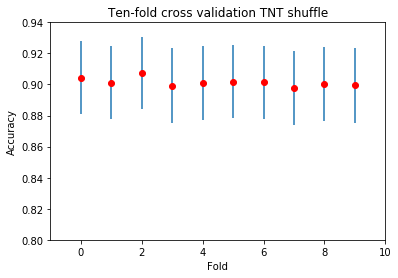

In [34]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_TNT_barajo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation TNT shuffle')
plt.plot(x,y,'ro')
Tic=[accuracy95(p,len(res)//k) for p in results]# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

In [35]:
print("Cross validation HMM %s" %(scuadrado(precisiones_HMM_no_barajo)) )
print("Cross validation TNT %s" %(scuadrado(precisiones_TNT_no_barajo)) )
print("Cross validation HMM with shuffle %s" %(scuadrado(precisiones_HMM_barajo)) )
print("Cross validation TNT with shuffle %s" %(scuadrado(precisiones_TNT_barajo)) )


Cross validation HMM [0.9046, 0.9054]
Cross validation TNT [0.8681, 0.8692]
Cross validation HMM with shuffle [0.9257, 0.9257]
Cross validation TNT with shuffle [0.9014, 0.9014]
